https://pjreddie.com/darknet/yolo/

https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg

https://github.com/pjreddie/darknet/blob/master/data/coco.names

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The coco.names file contains the names of the different objects that our model was trained upon

classes = []
with open('coco.names') as file:
    classes = [word.strip() for word in file.readlines()]
    
print(len(classes))

80


In [3]:
'person' in classes

True

In [4]:
# Loading YoloV3 weights and configuration file using dnn module

modelWeights = 'yolov3-416.weights'
modelConfig = 'yolov3-416.cfg'

network = cv2.dnn.readNet(modelWeights , modelConfig)
print(type(network))

<class 'cv2.dnn_Net'>


In [5]:
# Get the name of all layers of the network

layers_names = network.getLayerNames()
print(len(layers_names))

254


In [6]:
# To run a forward pass using the cv2.dnn module, we need to pass in the names of layers for which the output is to be computed

output_layers = network.getUnconnectedOutLayersNames()
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

### IMAGE

In [63]:
image = cv2.imread('images.jpg')
print(image.shape)

height , width , ch = image.shape

(280, 390, 3)


In [64]:
# Creates 4-dimensional blob from image i.e., returns 4-dimensional Mat with NCHW dimensions order
# Optionally resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels

blob = cv2.dnn.blobFromImage(image, scalefactor=1.0/255, size=(416,416), mean=(0,0,0), swapRB=True, crop=False)
print(type(blob) , blob.shape)

<class 'numpy.ndarray'> (1, 3, 416, 416)


In [65]:
# Sets the new input value for the network

network.setInput(blob)

In [66]:
# Runs forward pass to compute the outputs
# The forward() function of cv2.dnn module returns a nested list containing information about all the detected objects which includes the x and y , coordinates of the centre of the object detected , height and width of the bounding box , confidence and scores for all the classes of objects listed in coco.names.
# The class with the highest score is considered to be the predicted class.
# 3 different outputs corresponding to 3 output layers 

outputs = network.forward(output_layers)
len(outputs)

3

In [67]:
type(outputs)

list

In [68]:
# 1st output layer produces 507 bounding boxes 
# 85 columns are - center_x (scaled values in range 0 to 1) , center_y , width , height , confidence that there is an object present in this bbox 
# and rest 80 values are prediction probability over all classes
# same for other 2 output layers

print(type(outputs[0]) , '\n')

print(outputs[0].shape , outputs[1].shape , outputs[2].shape)

<class 'numpy.ndarray'> 

(507, 85) (2028, 85) (8112, 85)


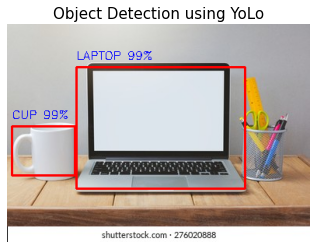

In [70]:
bboxes = []
class_ids = []
confidences = []

for output in outputs:
    for detection in output:          # detection = (85,)
        
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        
        if confidence > 0.5:           
            # center coordinates
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            
            # height and width
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            
            # top left coordinates
            x = int(center_x - w/2)
            y = int(center_y - h/2)
            
            bboxes.append([x , y , w , h])
            class_ids.append(class_id)
            confidences.append(float(confidence))
            
# Performs non maximum suppression given boxes and corresponding scores to eliminate overlapping boxes
indices = cv2.dnn.NMSBoxes(bboxes , confidences , 0.5 , 0.4)

for i in range(len(bboxes)):
    if i in indices:
        
        x , y , w , h = bboxes[i]
        label = str(classes[class_ids[i]])
        score = int(confidences[i]*100)
        
        cv2.rectangle(image, (x, y), (x+w, y+h), (0,0,255), 2)
        cv2.putText(image, f'{label.upper()} {score}%', (x , y-10), cv2.FONT_HERSHEY_SIMPLEX, 1/2, (255,0,0), 1)
        
cv2.imshow('Object Detection' , image)

plt.figure()
plt.imshow(cv2.cvtColor(image , cv2.COLOR_BGR2RGB))
plt.title('Object Detection using YoLo' , fontsize = 15)
plt.axis(False)
plt.show()

cv2.waitKey()
cv2.destroyAllWindows()        

In [71]:
bboxes

[[93, 53, 207, 140],
 [67, 39, 261, 172],
 [89, 55, 217, 156],
 [74, 46, 246, 176],
 [102, 53, 220, 159],
 [84, 41, 260, 186],
 [6, 131, 81, 63],
 [9, 126, 80, 73]]

In [72]:
confidences

[0.5869305729866028,
 0.5840204358100891,
 0.9936770796775818,
 0.96587073802948,
 0.7190912365913391,
 0.606051504611969,
 0.9944380521774292,
 0.9178484678268433]

In [73]:
class_ids

[63, 63, 63, 63, 63, 63, 41, 41]

In [75]:
indices

array([[6],
       [2]], dtype=int32)

### VIDEO

In [7]:
label = 'person'

cap = cv2.VideoCapture('walking.avi')

while True:
    ret , image = cap.read()
    if ret == False:
        print('Video Error')
        break
        
    height,width,ch = image.shape
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0/255, size=(416,416), mean=(0,0,0), swapRB=True, crop=False)
    network.setInput(blob)
    outputs = network.forward(output_layers)
    
    bboxes = []
    class_ids = []
    confidences = []

    for output in outputs:
        for detection in output:          # detection = (85,)
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
        
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w/2)
                y = int(center_y - h/2)
            
                bboxes.append([x , y , w , h])
                class_ids.append(class_id)
                confidences.append(float(confidence))
            
    indices = cv2.dnn.NMSBoxes(bboxes , confidences , 0.5 , 0.4)

    for i in range(len(bboxes)):
        if i in indices and label == str(classes[class_ids[i]]):
            x , y , w , h = bboxes[i]
            #label = str(classes[class_ids[i]])
            score = int(confidences[i]*100)
        
            cv2.rectangle(image, (x, y), (x+w, y+h), (0,0,255), 2)
            cv2.putText(image, f'{label.upper()} {score}%', (x , y-10), cv2.FONT_HERSHEY_SIMPLEX, 1/2, (0,0,0), 2)
            
    cv2.imshow('Object Detection' , image)
    
    if cv2.waitKey(25) == 13:
        break


cap.release()
cv2.destroyAllWindows()   

In [ ]:
cap.release()
cv2.destroyAllWindows()